## Experiment 2: Comparison between k-medoids and Fast k-medoids (section 3.3)

In [13]:
import os, sys, random, pickle
from datetime import datetime
from zoneinfo import ZoneInfo  
import polars as pl
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt  
from BigEDA.descriptive import outliers_table
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix
from FastKmedoids.plots import clustering_MDS_plot_multiple_methods
from PyDistances.mixed import FastGGowerDistMatrix, GGowerDistMatrix, get_dist_matrices, S_robust
from PyDistances.quantitative import robust_maha_dist_matrix
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cdist

sns.set_style('whitegrid')

current_path = os.getcwd()
src_path = os.path.join(current_path, '..', 'src')
config_path = os.path.join(current_path, '..', 'config')

sys.path.append(src_path)
sys.path.append(config_path)

from simulations_utils import get_simulation_1

from experiments_utils import (make_experiment_2, 
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names)

from config_experiment_2 import get_config as get_config_exp_2

In [14]:
experiment_2_config = get_config_exp_2()

In [15]:
from sklearn_extra.cluster import KMedoids
from FastKmedoids.models import FastKmedoidsGGower

models = {
    'KMedoids-euclidean': KMedoids(n_clusters=experiment_2_config['n_clusters'], 
                                   metric='euclidean', 
                                   method=experiment_2_config['method'], 
                                   init=experiment_2_config['init'], 
                                   max_iter=experiment_2_config['max_iter'], 
                                   random_state=experiment_2_config['random_state']),

    'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': FastKmedoidsGGower(
            n_clusters=experiment_2_config['n_clusters'], 
            method=experiment_2_config['method'], 
            init=experiment_2_config['init'], 
            max_iter=experiment_2_config['max_iter'], 
            random_state=experiment_2_config['random_state'],
            frac_sample_size=experiment_2_config['frac_sample_size'], 
            p1=experiment_2_config['p1'], 
            p2=experiment_2_config['p2'], 
            p3=experiment_2_config['p3'], 
            d1='robust_mahalanobis', 
            d2='jaccard', 
            d3='hamming', 
            robust_method='trimmed', 
            alpha=experiment_2_config['alpha'], 
            epsilon=experiment_2_config['epsilon'], 
            n_iters=experiment_2_config['n_iters'],
            VG_sample_size=experiment_2_config['VG_sample_size'], 
            VG_n_samples=experiment_2_config['VG_n_samples']) 

}


In [ ]:
n_realizations = 70
experiment_random_state = 123 
random.seed(experiment_random_state)
random_state_list = random.sample(range(n_realizations*1000), n_realizations)

In [17]:
results, problematic_random_state = {}, []

for random_state in random_state_list: 
    print('random_state', random_state)  
    
    try:
        results[random_state] = make_experiment_2(
           n_samples_list = experiment_2_config['n_samples_list'], 
           models = models, 
           random_state = random_state
        )
    except Exception as e:
        problematic_random_state.append(random_state)
        print(f'Exception: {e}')

# Time 1 realization: 
## Personal computer
## IBiDat server: 9.20 mins

random_state 428
KMedoids-euclidean
5000
10000
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
5000
10000
random_state 2192
KMedoids-euclidean
5000
10000
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
5000
10000
random_state 714
KMedoids-euclidean
5000
10000
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
5000
10000
random_state 3336
KMedoids-euclidean
5000
10000
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
5000
10000
random_state 2183
KMedoids-euclidean
5000
10000
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
5000
10000


In [ ]:
results_folder_path = os.path.join(current_path, '..', 'results', 'results_experiment_2')
os.makedirs(results_folder_path, exist_ok=True)
id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
results_filename = f'results_experiment_2_{id}.pkl'
results_save_path = os.path.join(results_folder_path, results_filename)

In [10]:
# Save results
with open(results_save_path, 'wb') as f:
    pickle.dump(results, f)

In [11]:
# Open results
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [18]:
model_names = list(models.keys())

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = experiment_2_config['n_samples_list'], 
                                  iterable2 = model_names)

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = experiment_2_config['n_samples_list'], 
                                  iterable2 = model_names)

dfs = avg_results_to_dfs(avg_results, column_1='n_samples', column_2='model_name')

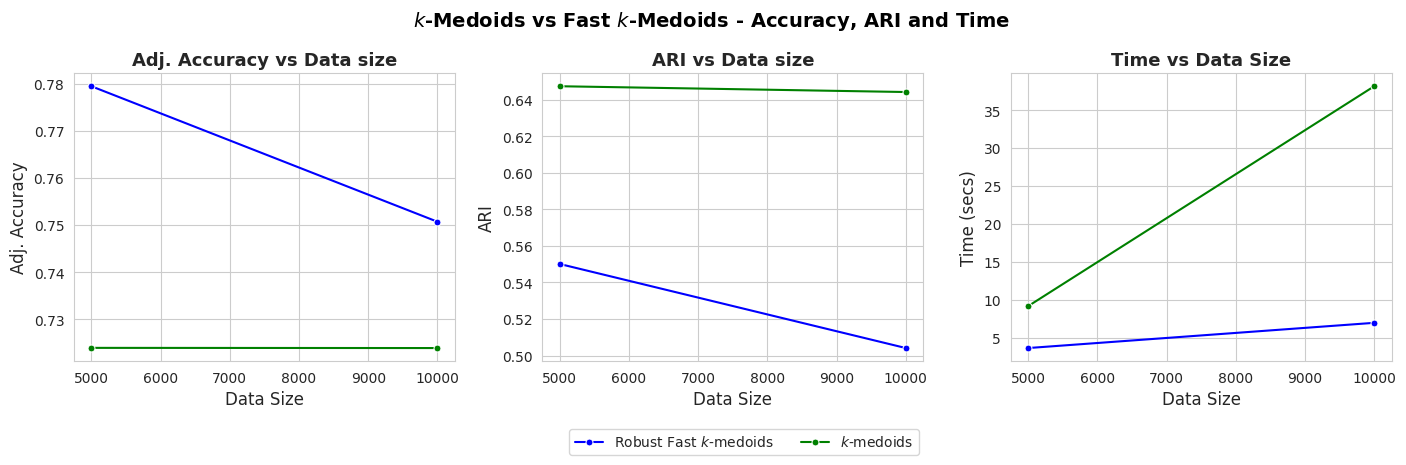

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(17,4))
axes = axes.flatten()  

#######################################################################
# Accuracy plot 
#######################################################################

model_name = 'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming'
df_acc_subset = dfs['adj_accuracy'][dfs['adj_accuracy']['model_name'] == model_name]

sns.lineplot(x=df_acc_subset['n_samples'], 
             y=df_acc_subset['adj_accuracy'], 
             color='blue', marker='o',  markersize=5, 
             label=model_name, ax=axes[0])

################################

model_name = 'KMedoids-euclidean'
df_acc_subset = dfs['adj_accuracy'][dfs['adj_accuracy']['model_name'] == model_name]

sns.lineplot(x=df_acc_subset['n_samples'], 
             y=df_acc_subset['adj_accuracy'], 
             color='green', marker='o',  markersize=5, 
             label=model_name, ax=axes[0])


#######################################################################
# ARI plot 
#######################################################################

model_name = 'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming'
df_acc_subset = dfs['ARI'][dfs['ARI']['model_name'] == model_name]

sns.lineplot(x=df_acc_subset['n_samples'], 
             y=df_acc_subset['ARI'], 
             color='blue', marker='o',  markersize=5, 
             label='Robust Fast $k$-medoids', ax=axes[1])

################################

model_name = 'KMedoids-euclidean'
df_acc_subset = dfs['ARI'][dfs['ARI']['model_name'] == model_name]

sns.lineplot(x=df_acc_subset['n_samples'], 
             y=df_acc_subset['ARI'], 
             color='green', marker='o',  markersize=5, 
             label='$k$-medoids', ax=axes[1])


#######################################################################
# Time plot 
#######################################################################

model_name = 'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming'
df_time_subset = dfs['time'][dfs['time']['model_name'] == model_name]

sns.lineplot(x=df_time_subset['n_samples'], 
             y=df_time_subset['time'], 
             color='blue', marker='o',  markersize=5, 
             label=model_name, ax=axes[2])

################################

model_name = 'KMedoids-euclidean'
df_time_subset = dfs['time'][dfs['time']['model_name'] == model_name]

sns.lineplot(x=df_time_subset['n_samples'], 
             y=df_time_subset['time'], 
             color='green', marker='o',  markersize=5, 
             label=model_name, ax=axes[2])

#######################################################################
# Plot details

axes[0].set_title('Adj. Accuracy vs Data size', size=13, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=12)
#min_acc = min([min(best_accuracy[model].values()) for model in model_names])
#max_acc = max([max(best_accuracy[model].values()) for model in model_names])
#axes[0].set_yticks(np.round(np.linspace(min_acc, max_acc, 6),3))

axes[1].set_title('ARI vs Data size', size=13, weight='bold')
axes[1].set_ylabel('ARI', size=12)


axes[2].set_title('Time vs Data Size', size=13, weight='bold')
axes[2].set_ylabel('Time (secs)', size=12)
#min_time = min([min([x for x in times[model].values() if x != None]) for model in model_names])
#max_time = max([max([x for x in times[model].values() if x != None]) for model in model_names])
#axes[1].set_yticks(np.round(np.linspace(min_time, max_time, 6),3))

for i in range(len(axes)):
    #axes[i].set_xticks(data_sizes + [25000, 35000, 45000])
    axes[i].set_xlabel('Data Size', size=12)
    axes[i].legend().set_visible(False)

handles, labels = axes[1].get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, loc='lower center', bbox_to_anchor=(-0.7, -0.35), ncol=len(labels), fontsize=10)
plt.subplots_adjust(top=0.83)
plt.suptitle('$k$-Medoids vs Fast $k$-Medoids - Accuracy, ARI and Time', fontsize=14, y=0.99, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'results_experiment_2_{id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

**Nota:** si queremos que los datos de tiempo sean coherentes con mi pc personal hay que multiplicarlos por 2, ya que el experimento ha sido corrido con el server, y en base a mis pruebas piloto, el serber acorta los tiempos a la mitad, aprox.



**Nota:** si los resultados no están siendo los esperados habrá que adaptar el parametro frac_sample_size en función de data size, por tramos/intervalos, como se hizo en el TFM. Auque esto segsa los resultado sfavorablemente hacia nuestro metodo, hay que sacar esto adelante como sea, y en el fondo lo más probable es que no se enteren del uso de este sesgo positivo.

**Nota:** si los resultados para ARI no salen positivos, lo quitamos